# Contour detection for online monitorring of video data

**Problem statement**: We want to monitor an area of the world in which an animal must be present in order to obtain a reward. The critical area is a unique white rectangle that is usually in the center of the image, but may change position if the camera is moved. We want to:
1. Build an automated system for detecting the position of the critical region across small camera movements and variations in light levels
2. Monitor that area to detect when an animal is present

The images below show two frames without the animal present (top) and with the animal present (bottom):

<img src="./img/not_present.png" alt="animal not present at key area" width=300 class='center'><br>
<img src="./img/present.png" alt="animal not present at key area" width=300>

This notebook shows how we created a simple contour detection script to run automatically as part of the data acqusition system and record whether the animal was present or absent on each frame over time. The demonstration reads frames from an example video used for development purposes, but the code is written to be 'plug-and-play' with an incoming stream of frames sourced from a realsense (or any other) camera.

## Step 1: Reading frames

Start by loading an example frame to show the data we'll be working with. Note that all frames are converted to grayscale for contour detection

In [1]:
import os, sys
from pathlib import Path
from dotenv import load_dotenv

# Load environmental paths (unique to host machine)
load_dotenv()

# Specify path the demo video
video_path = Path(os.getenv("data_path"))
video_file = '2018-06-15_Track_14-51-22.avi'

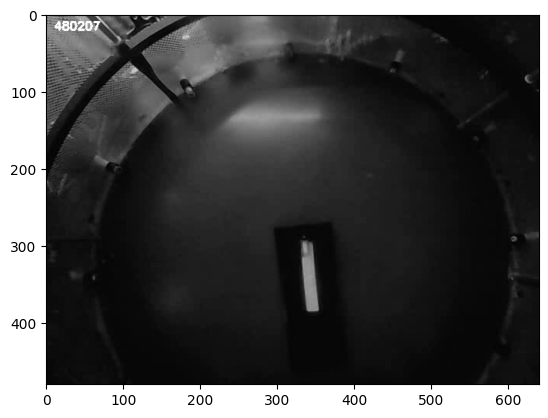

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

cap = cv2.VideoCapture(str(video_path/video_file))

ret, frame = cap.read()
BW = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

plt.imshow(BW, cmap='gray')
plt.show()

## Step 2. Image segmentation

We start the image segmentation process by thresholding to separate the white rectangle from the black background. In the first frames of the video, we also have a lot of light at the front of the test arena and this creates some additional white areas that we will want to discard later.

Note that we use the THRESH_BINARY_INV flag to invert the process, so that the white areas we're interested become dark areas in the thresholded image.

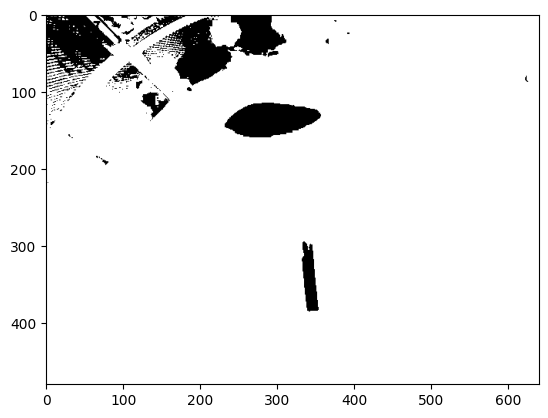

In [3]:
signal_threshold = 100

ret, tImg = cv2.threshold(BW, signal_threshold, 255, cv2.THRESH_BINARY_INV)

plt.imshow(tImg, cmap='gray')
plt.show()

Next we get contours from thresholded image and plot them to check they make sense. Note that it is sometimes the case that a contour is created around the entire image (not helpful).



There are 367 contours


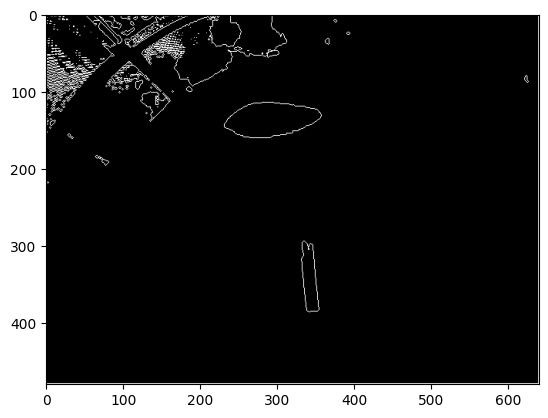

In [4]:
contours, hierarchy = cv2.findContours(tImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours 
mask = np.zeros_like(tImg)

for i, contour in enumerate(contours):
    cv2.drawContours(mask, contours, i, color=255, thickness=1)   # Apply contours to mask and fill (thickness=-1)

print(f"There are {len(contours)} contours")
plt.imshow(mask, cmap='gray')
plt.show()


The area within the contour is the key metric for identifying the rectangle of interest. Let's look at the distribution of contour areas, excluding any contours that cover more than a quarter of the image (to remove that unhelpful contour of the whole image)

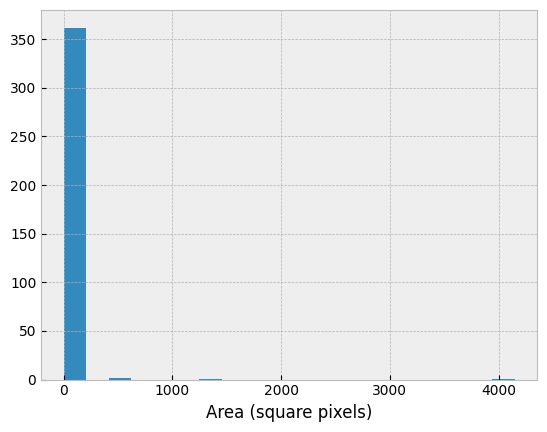

In [5]:
contour_area = np.array([cv2.contourArea(contour) for contour in contours])

# Mask areas covering more than a quarter of the image
total_pix = (frame.shape[0] * frame.shape[1]) 
contour_area[contour_area > (total_pix/4)] = np.nan

# Plot area distribution
plt.style.use('bmh')
fig, ax = plt.subplots()

ax.hist(contour_area, bins=20)
ax.set_xlabel('Area (square pixels)')
plt.show()

With a little trial and error, we can find the range of areas that uniquely identifies the white rectangle. Here, we plot the masked data with an in-fill for the contour (we didn't do this before as it can be confusing if the whole image is filled by a single contour)

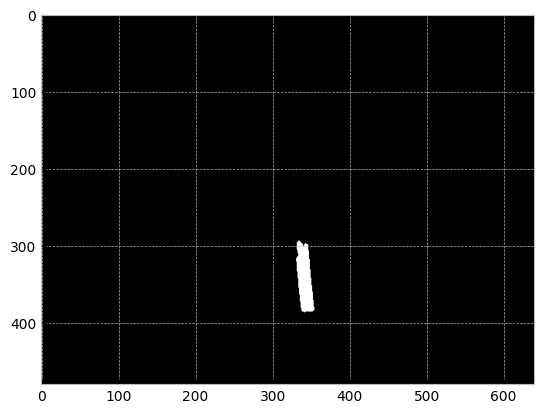

In [7]:
mask = np.zeros_like(tImg)
area_lim = (1000, 2000)

for i, contour in enumerate(contours):
    if area_lim[0] < cv2.contourArea(contour) < area_lim[1]:
        cv2.drawContours(mask, contours, i, color=255, thickness=-1)  

plt.imshow(mask, cmap='gray')
plt.show()

By filling in the values in the image above, we can identify most of the pixels in the image that contribute to the region of interest. We can then select those pixels from the original image and use the mean intensity as a signal of whether the animal was there or not. In the code below, we'll do this first for a single frame and then for many frames from a video to show how the code can be integrated with incoming frames during live capture.

Note that when sampling from color videos or sensors, we don't convert the test frames to grayscale. It's faster just to rely on the correlation between color channels and compute means on a single channel (e.g. green).

In [8]:
# Get pixels of interest
pts = np.where(mask == 255)

# Rescale image from 0:255 to 0:1 (legacy scale)
frame = frame / 255

# Get intensitities for those points in the green image
intensities = frame[pts[0], pts[1], 1]

# Initialize list of center value as mean across all pixels
centerVal = [intensities.mean()]
print(centerVal)

[0.5049184657027794]


Note that the value above doesn't mean much because it only shows how strong the intensity of pixels are when the animal is not present. We need to find frames when the animal is present, to make sure that there's some difference in the metric. Below we'll run through some of the video to extract the metric over time and determine if the metric is a useful diagnostic.

In [9]:
centerVal = []

while(cap.isOpened()):

    # Read next frame
    ret, frame = cap.read()

    # if you got a frame, ask what the center value was
    if ret == True:

        # Rescale image from 0:255 to 0:1 (legacy scale)
        frame = frame / 255

        # Get intensitities for those points in the green image
        intensities = frame[pts[0], pts[1], 1]

        # Initialize list of center value as mean across all pixels
        centerVal.append(intensities.mean())
    else:
        break

    if len(centerVal) > 900:            # Stop early 
        break

    if len(centerVal) % 100 == 0:            # Update user
        print(f"Completed frame {len(centerVal)}")

Completed frame 100
Completed frame 200
Completed frame 300
Completed frame 400
Completed frame 500
Completed frame 600
Completed frame 700
Completed frame 800
Completed frame 900


If we look at a plot of the metric ("signal values") across time, we can see that there are clear drops in the value that are consistent with the presence of the animal. We would intuitively expect the signal value to drop when the animal was present because the subject is darker than the white rectangle that we originally detected. (This is why we used white rather than black to mark the zone - though such a system would not work with albino individuals).

The histogram actually indicates that there may be more than two peaks in the metric distribution, suggesting that the animal may regularly cover only part of the target area. Whether we want to consider that as worthy of reward might depend on operational requirements; however because we can return a continuous value (rather than a discrete yes or no), we can allow users to choose for themselves by setting a parameter in the data acquisition software to their preferred threshold (some users may be very strict, others might be more generous - particularly during early phases of behavioral training).

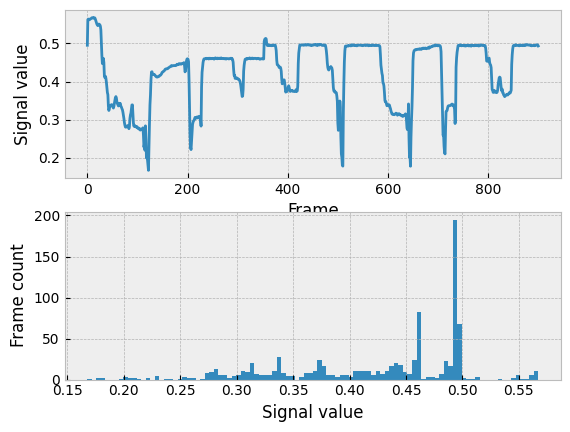

In [10]:
fig, axs = plt.subplots(2,1)

axs[0].plot(centerVal)              # Line plot of signal value vs frame
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Signal value')

axs[1].hist(centerVal, bins=100)    # Distribution of signal values
axs[1].set_xlabel('Signal value')
axs[1].set_ylabel('Frame count')

plt.show()

# Step.4. Validation

If the signal we're extracting is informative about the presence or absence of the animal over the white rectangle, we should be able to work backwards and check that those signal values below a certain point are indeed frames when the animal is present. We can do that here by extracting specific frames in which the signial is indicative of the absence of the animal.

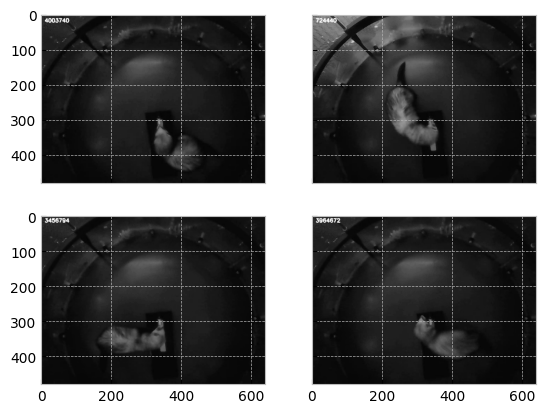

In [13]:
present_threshold = 0.35
samples_to_plot = 4

frames_of_interest = [i for (i, v) in enumerate(centerVal) if v < present_threshold]

# Randomly shuffle to see different instances
import random
random.shuffle(frames_of_interest)

# Plot a montage of example images
nrows = int(np.ceil(np.sqrt(sample)))
ncols = nrows

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True)
axs = axs.ravel()

for idx, ax in enumerate(axs):

    cap.set(cv2.CAP_PROP_POS_FRAMES, frames_of_interest[idx])

    ret, frame = cap.read()
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    ax.imshow(gray_image, cmap='gray')

cap.release()
plt.show()

We can see that the system successfully picks out those cases where the animal approaches the critical area from a variety of directions and with a range of poses.

## 5. Running for entire videos

The file [contour_detection.py](./contour_detection.py) contains much of the code described in this note book, in a form that's convenient to work with for video sources, as well as some minor refactoring. An example of the tracking data obtained from the demo video is saved in the repository as [2018-06-15_Track_14-51-22_pixelintensities.dat](./2018-06-15_Track_14-51-22_pixelintensities.dat) and plotted below for reference.

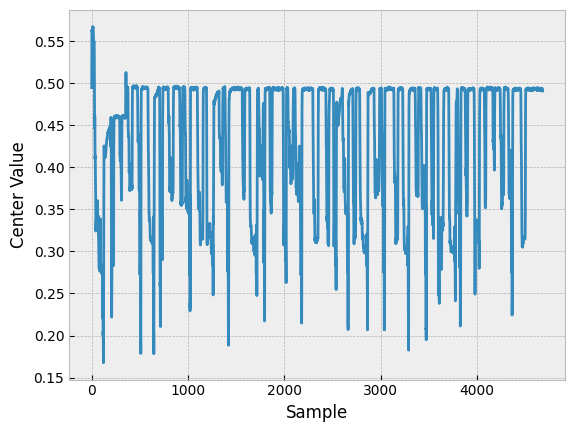

In [21]:
all_frames = np.loadtxt('./2018-06-15_Track_14-51-22_pixelintensities.dat')

plt.plot(all_frames)
plt.xlabel('Sample')
plt.ylabel('Center Value')
plt.show()

## 6. Improvements

Through the notebook, it's obvious that there are places where we could use alternative methods. One particular example is in the use of a pre-specified area for the white rectangle. For our use case, where the camera can be translated or rotated slightly (usually by accident), but retains a roughly constant distance from the target, this isn't a problem. However if one were to apply this system across different distances, the parameters for area limits would need to be updated. It would be better to have a scale invariant system such as a convnet classifier but this requires more sophisticated approaches that we don't need for our particular application.

One of the advantage of our system is its speed. The region of interest is defined once and then the points within the region are used to sample pixels in every incoming frame. This requires very little additional processing because the data is already streaming and the frame information is available as the output video is being written. We're simply performing an indexing operation to compute the mean, which should be relatively fast (so long as the camera image isn't huge - these videos are 480 x 640).